#  Plot NREL 2.3-116 Performance curve for AMR-Wind+OpenFAST and also Joukowski model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from netCDF4 import Dataset

%matplotlib inline

# Important header information
amrwindfedir = '/projects/wind_uq/lcheung/amrwind-frontend/'  # where amrwind-frontend resides
import sys, os
sys.path.insert(1, amrwindfedir)
import OpenFASTutil as OpenFAST

In [2]:
# Load ruamel or pyyaml as needed
try:
    import ruamel.yaml as yaml
    print("# Loaded ruamel.yaml")
    useruamel=True
    loaderkwargs = {'Loader':yaml.RoundTripLoader}
    dumperkwargs = {'Dumper':yaml.RoundTripDumper, 'indent':4, 'default_flow_style':False} 
except:
    import yaml as yaml
    print("# Loaded yaml")
    useruamel=False
    loaderkwargs = {}
    dumperkwargs = {'default_flow_style':False }
    
if useruamel: Loader=yaml.load
else:         Loader=yaml.safe_load

# Loaded ruamel.yaml


In [3]:
# Define some helper functions

def avgoutputs(pddat, tavg, keys, timekey='Time'):
    """
    Function to average the pddat over a specific time
    """
    t = pddat[timekey].values
    
    # Filter the appropriate times
    timefilter = (tavg[0]<=t)&(t<=tavg[1])
    tfilter   = t[timefilter]
    # Get the total time
    dt = np.amax(tfilter) - np.amin(tfilter)

    outdict = {}
    for key in keys:
        #f = pddat[key].values
        outdict[key] = np.trapz(pddat[key].values[timefilter], x=tfilter, axis=0) / dt
    return outdict

def avgoutputsJski(ncdat, tavg, keys, timekey='time'):
    """
    Function to average the pddat over a specific time
    """
    t = np.array(ncdat.variables[timekey])
    
    # Filter the appropriate times
    timefilter = (tavg[0]<=t)&(t<=tavg[1])
    tfilter   = t[timefilter]
    # Get the total time
    dt = np.amax(tfilter) - np.amin(tfilter)
    outdict = {}
    for key in keys:
        #f = pddat[key].values
        #print(ncdat.variables[key])
        outdict[key] = np.trapz(ncdat.variables[key][timefilter], x=tfilter, axis=0) / dt
    return outdict

readoutfile = lambda f: pd.read_csv(f,sep='\s+',skiprows=(0,1,2,3,4,5,7), header=(0),skipinitialspace=True)

def calcCt(p,  rho, U, rmax, ctkey='RtAeroFxh', tfunc=lambda x: x):
    thrust = tfunc(p[ctkey])
    A = np.pi*rmax*rmax
    Q = 0.5*rho*U*U*A
    Ct = thrust/Q
    return Ct

# Grep a file for a pattern
def grepfile(filename, pattern):
    file = open(filename, "r")
    for line in file:
        if line.startswith(pattern):
            return line
    return None

# Stuff for loading calibration runs
def merge_two_dicts(x, y):
    for k, g in y.items(): x[k] = g
    return x

def loadLogFile(logfile, extradict={}):
    # Load a log file
    fp = open(logfile, 'r')
    yamldict = Loader(fp, **loaderkwargs)
    fp.close()
    returnlist=[]
    for k, g in yamldict.items():
        returnlist.append(merge_two_dicts(g, extradict))
    return returnlist

def avgNCdat(ncfile, turbname, tavg, avgq):
    ncdat = Dataset(ncfile)
    return avgoutputsJski(ncdat[turbname], tavg, avgq)

def loadPC_OF(logfile, extradict, firsttag, outfile, tavg, avgq, prefixdir=''):
    PC = loadLogFile(prefixdir+logfile, extradict=extradict)
    # Set up the first tag
    PC[0]['tag'] = firsttag
    # Set up the out files
    for x in PC: 
        x['outfile']=prefixdir+x['dir']+outfile
    # Load the power curves from the netCDF data
    for pc in PC:
        datafile = pc['outfile']
        outdat   = readoutfile(datafile)
        pc.update(avgoutputs(outdat, tavg, avgq))
        #pc.update(avgNCdat(datafile, turbname, tavg, avgq))
    return PC

def loadPC_Joukowski(logfile, extradict, firsttag, ncfile, turbname, tavg, avgq, prefixdir=''):
    PC = loadLogFile(prefixdir+logfile, extradict=extradict)
    # Set up the first tag
    PC[0]['tag'] = firsttag
    # Set up the out files
    for x in PC: 
        x['outfile']=prefixdir+x['dir']+ncfile
    # Load the power curves from the netCDF data
    for pc in PC:
        datafile = pc['outfile']
        pc.update(avgNCdat(datafile, turbname, tavg, avgq))
    return PC

In [4]:
# Global averaging parameters
tavg = [300, 360]
avgqJ = ['power', 'cp', 'ct', 'total_disk_force', 'angular_velocity', 'vdisk', 'vref', 'angular_velocity']
avgq = ['GenPwr', 'RotSpeed',  'RtAeroFxh'] #['GenPwr', 'RotSpeed', 'BldPitch1', 'RotTorq','RtAeroCt','RtAeroFxh']
#avgq = ['GenPwr', 'RotSpeed', 'BldPitch1', 'GenTq','RotTorq','RtAeroCt']
pcvar= ['generator power [kW]', 'rotor speed [RPM]',  'rotor thrust [kN]',
        'rotor torque [kN-m]','Ct [-]','blade pitch [deg]', ]

#translatedict={'GenPwr':'power'}#, 'RotSpeed':'angular_velocity', 'RtAeroFxh':'total_disk_force'}

rho  = 1.225
rmax = 0.5*116.0

## Load the OpenFAST only runs

In [5]:
# Load the OpenFAST only data
#basedir = '/pscratch/ndeveld/ldrd-awc/of-sims/wind-sweep-NREL-2p8-127-5_10_22/power_curve'
#basedir = '/pscratch/ndeveld/awaken/turbine_calibrations/NREL-2p3-116_nofllc/awaken-ofp-nrel23116/power_curve'   # Add something here to load the OpenFAST only runs'
basedir = ''
prefix  = 'nrel23116_'
wsvec   = np.arange(3, 16, 0.5)
PC_OpenFAST = []

# Load the data
if len(basedir)>0:
    for ws in wsvec:
        #datafile = basedir+'/'+prefix+str(ws)+'mps'+'/'+prefix+str(ws)+'mps.out'
        datafile = basedir+'/'+prefix+str(ws)+'mps'+'/NREL-2p3-116.out'
        print(datafile)
        outdat   = readoutfile(datafile)
        outdict  = avgoutputs(outdat, [120, 180], avgq)
        outdict['WS'] = ws
        #for i, bstr in enumerate(['B1N%iFx', 'B2N%iFx', 'B3N%iFx']):
        #    outdict['B%iFx'%i] = mergebladeprop(outdict, bstr, range(1,10))
        #outdict['B2Fx'] = mergebladeprop(outdict, 'B2N%iFx', range(1,10))
        #outdict['B3Fx'] = mergebladeprop(outdict, 'B3N%iFx', range(1,10))
        PC_OpenFAST.append(outdict)

## Load the AMR-Wind runs

In [6]:
# Load AMR-Wind OpenFAST data

# Change this directory to wherever the cases were run
#amrdir = '/nscratch/lcheung/2021/AWAKEN/turbinerun/GE2.8-127/testCalibrate/' 
amrdir = '/pscratch/mlblayl/AWAKEN/OF_NREL-2.3-116v2/NewMods/'   # Add something here to load the AMR-Wind OF runs
#natedir= '/pscratch/ndeveld/awaken/turbine_calibrations/NREL-2p3-116_nofllc/awaken-joukowsky-tune-3/'
natedir= '/pscratch/ndeveld/awaken/turbine_calibrations/NREL-2p3-116_nofllc/awaken-joukowsky-tune-3/'
#RunCalibration_Joukowski_Eps5.00_logfile.yaml
#PC_amr = [] #OrderedDict()

#if len(amrdir)>0:
#    PC_amr = loadPC_OF('RunCalibration_Eps5.00_logfile.yaml',
#              {'tag':'', 'ms':'s', 'mfc':'c', 'color':'c'}, 
#              'AMR-Wind ADM $\epsilon=5$', 
#              '../awaken-ofp-nrel23116/power_curve/NREL-2p3-116.out', tavg, avgq, prefixdir=natedir)

In [7]:
PC_jski = [] #OrderedDict()

PC_jski = loadPC_Joukowski('RunCalibration_Joukowski_Eps5.00_logfile.yaml',
              {'tag':'', 'ms':'o', 'mfc':'b', 'color':'b'}, 
              'AMR-Wind ADM-Joukowski $\epsilon=5$', 
              '/post_processing/actuator00000/T0.nc', 'T0', tavg, avgqJ, prefixdir=amrdir)

PC_jski2 = [] #OrderedDict()

#PC_jski2 = loadPC_Joukowski('RunCalibration_Joukowski_EPS5.00_VC10.00_logfile.yaml',
#              {'tag':'', 'ms':'o', 'mfc':'r', 'color':'r'}, 
#              'AMR-Wind ADM-Joukowski $\epsilon=5$ VC=10', 
#              '/post_processing/actuator00000/T0.nc', 'T0', tavg, avgqJ, prefixdir=amrdir)

In [8]:
# Get original design power curve
# Note that this file is available at https://github.com/NREL/openfast-turbine-models/tree/master/IEA-scaled/NREL-2.8-127
#pc = pd.read_csv('NREL-2.8-127.csv')

In [9]:
# Get original design power curve
pc = pd.read_csv('NREL-2.3-116v2.csv')

```
# Load the design power curve from the yaml definitions
turbyamlfile = amrwindfedir+'turbines/GE24-107_calib.yaml'
fp = open(turbyamlfile, 'r')
turbyamldict = Loader(fp, **loaderkwargs)
fp.close()
turbmodel = turbyamldict['turbines']['Joukowski_GE24-107_calibLCC']
#print(turbmodel)

# Convert the dict to the pc format
pc = {}
pc['wind speed [m/s]']  = [float(x) for x in turbmodel['Actuator_wind_speed'].split()]
pc['Ct [-]']            = [float(x) for x in turbmodel['Actuator_thrust_coeff'].split()]
pc['rotor speed [RPM]'] = [float(x) for x in turbmodel['Actuator_rpm'].split()]
pc['Cp [-]']            = [float(x) for x in turbmodel['cp_table'].split()]
A  = np.pi*rmax**2
#pc['generator power [kW]'] = [float(x)/1000 for x in AeroPwr.split()] #0.5*rho*A*np.array(pc['Cp [-]'])*np.array(pc['wind speed [m/s]'])**3/1000
pc['generator power [kW]'] = 0.5*rho*A*np.array(pc['Cp [-]'])*np.array(pc['wind speed [m/s]'])**3/1000
pc['aerodynamic power [kW]'] = 0.5*rho*A*np.array(pc['Cp [-]'])*np.array(pc['wind speed [m/s]'])**3/1000/0.9
Nws  = len(pc['wind speed [m/s]'])
pc['blade pitch [deg]']   = np.zeros(Nws)
pc['rotor torque [kN-m]'] = np.zeros(Nws)
pc['rotor thrust [kN]']   = np.zeros(Nws)
#print(pc['generator power [kW]'])
#print(len(pc['Cp [-]']))
#print(len(pc['wind speed [m/s]']))
```

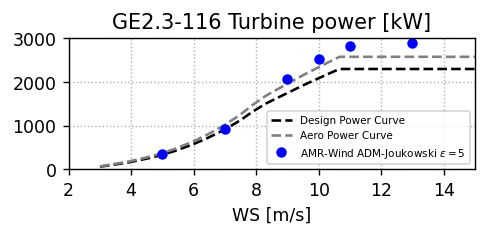

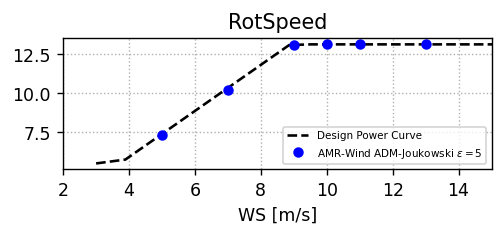

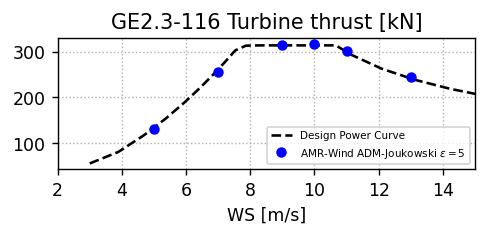

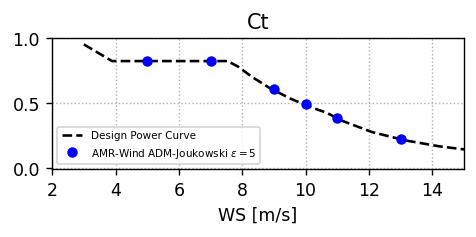

In [12]:
# Put curves to plot here
#plotcurves = PC_amr 
plotJski   = PC_jski + PC_jski2

figsize = (4,2)
dpi     = 125
turbmodel = 'GE2.3-116'
# Plot quantities
for iq, q in enumerate(avgq):
    plt.figure(q, figsize=figsize, dpi=dpi)
    # Plot original power curve
    plt.plot(pc['wind speed [m/s]'], pc[pcvar[iq]], 'k--', label='Design Power Curve')
    
    # Plot OpenFAST powercurve
    p = [x[q] for x in PC_OpenFAST] 
    if len(p)>0:
        scale=1000.0 if max(np.array(p))>10000 else 1.0
        #scale=1
        plt.plot(wsvec, np.array(p)/scale, 'k-.', label='OpenFAST only', linewidth=0.5)

    # Plot AMR-Wind power curve
#    for p in plotcurves:
#        scale=1000.0 #if np.max(p[q])>10000 else 1.0
#        mfc='w' if 'mfc' not in p else p['mfc']
#        plt.plot(p['WS'], p[q]/scale, marker=p['ms'], mfc=mfc, mec=p['color'], linewidth=0, ms=5, label=p['tag'])


    plt.legend(fontsize=6) # loc='lower right',
    plt.xlabel('WS [m/s]')
    plt.xlim([2,15])
    plt.grid(linestyle=':')
    plt.title(q)
    plt.tight_layout()

# ==== Plot some Joukowski variables ==================
plt.figure('GenPwr')
plt.plot(pc['wind speed [m/s]'], pc['aerodynamic power [kW]'], '--', color='gray', label='Aero Power Curve')
for p in plotJski:
    scale=1000
    mfc='w' if 'mfc' not in p else p['mfc']
    plt.plot(p['WS'], p['power']/scale, 
             marker=p['ms'], mfc=mfc, mec=p['color'], linewidth=0, ms=5, label=p['tag'])
    plt.legend(fontsize=6)
plt.title('%s Turbine power [kW]'%turbmodel)
plt.ylim([0, 3000])
plt.savefig('%s-GenPwr.png'%turbmodel)
    
plt.figure('RotSpeed')
for p in plotJski:
    scale=60.0/(2.0*np.pi)
    mfc='w' if 'mfc' not in p else p['mfc']
    plt.plot(p['WS'], p['angular_velocity']*scale, 
             marker=p['ms'], mfc=mfc, mec=p['color'], linewidth=0, ms=5, label=p['tag'])
    plt.legend(fontsize=6)
#plt.plot(pc['wind speed [m/s]'], np.array(pc['Cp [-]'])/np.array(pc['Ct [-]'])*np.array(pc['wind speed [m/s]'])*60.0/(2.0*np.pi)/(0.5*82.5), '--', label='$\Omega')

plt.figure('RtAeroFxh')
for p in plotJski:
    scale=1000.0 #if np.max(p[qjski])>10000 else 1.0
    mfc='w' if 'mfc' not in p else p['mfc']
    plt.plot(p['WS'], -p['total_disk_force'][0]/scale, 
             marker=p['ms'], mfc=mfc, mec=p['color'], linewidth=0, ms=5, label=p['tag'])
    plt.legend(fontsize=6)
plt.title('%s Turbine thrust [kN]'%turbmodel)
plt.savefig('%s-thrust.png'%turbmodel)

# ======== Plot real Ct ================
plt.figure("Ct", figsize=figsize, dpi=dpi)
plt.plot(pc['wind speed [m/s]'], pc['Ct [-]'], 'k--', label='Design Power Curve')

#for p in plotcurves:
#    density = p['rho'] if 'rho' in p else rho
#    ctx = calcCt(p, density, p['WS'], rmax)
#    mfc='w' if 'mfc' not in p else p['mfc']
#    plt.plot(p['WS'], ctx, marker=p['ms'], mfc=mfc, mec=p['color'], linewidth=0, ms=5, label=p['tag'])

for p in plotJski:
    density = p['density'] if 'density' in p else rho
    ctx = calcCt(p, density, p['vref'][0], rmax, ctkey='total_disk_force', tfunc=lambda x: -x[0])
    mfc='w' if 'mfc' not in p else p['mfc']
    plt.plot(p['WS'], ctx, marker=p['ms'], mfc=mfc, mec=p['color'], linewidth=0, ms=5, label=p['tag'])

ct = [calcCt(x, rho, x['WS'], rmax) for x in PC_OpenFAST] 
if len(ct)>0:
    plt.plot(wsvec, ct, 'k-.', label='OpenFAST only', linewidth=0.5)
    
    
plt.legend(fontsize=6) # loc='lower right',
plt.xlabel('WS [m/s]')
plt.xlim([2,15])
plt.grid(linestyle=':')
plt.title('Ct')
plt.tight_layout()